***

# **Project Name**: COVID-19 Analysis for Mexico (Year 2020)
## **Data Source**: Zambrano Hellion Hospital, TEC Salud, Mexico Secretariat of Health
### **Author**: Elvin Urbaez

**Date**: Apr, 2024


Note: In order to properly run this notebook, make sure to have the following datasets in the same folder as this notebook:

- coordinates.xlsx
- covid_data.xlsx
- mexicoHigh.json

***


## Table of Contents
1. [Installing and importing packages](#1)
2. [Data Preprocessing](#2)
3. [Exploratory Data Analysis](#3)

    a. [Data Visualization](#3a)
  
    b. [Statistical Analysis](#3b)
  
    c. [Correlation Graphs](#3c)
    
  
4. [Machine Learning Models](#4)

    a. [4.a XG Boost on Initial Data (no resampling, no hyper-parameter tuning)](#4a)
    
    b. [Resampling: SMOTE vs Random Oversampling vs Random Undersampling](#4b)
    
    c. [Searching for the best threshold using the ROC Curve](#4c)
    
    d. [Hyper-parameter tuning with best resampler method](#4d)
    

5. [Best Model](#5)

    a. [Interpretating best features](#5a)

***

## **1. Installing and importing packages**  <a class="anchor" id="1"></a>


Installation of packages to be used: Optuna, Unidecode and Shap. Optuna will be used for hyper-parameter tuning; Unidecode will serve us to remove special characters; and Shap will be used to visualize the importance of each feature in our model.

In [4]:
!pip install optuna
!pip install unidecode
!pip install shap
!pip install xgboost

In [3]:
pip install xgboost

     |████████████████████████████████| 2.2 MB 7.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Importing libraries for data processing and manipulation, along with machine learning libraries.

In [48]:
import pandas as pd
from unidecode import unidecode
import numpy as np
import folium
from folium.plugins import HeatMap
import json
import statistics as stats
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, f1_score, classification_report
import optuna
from sklearn.metrics import roc_curve, auc
import shap
import matplotlib.pyplot

Importing data in JAVA language (for our maps) and excel (for data processing and analysis).

In [8]:
with open('mexicoHigh.json', 'r') as file:
  geojson_data = json.load(file)

Making sure the file is being read properly.

In [ ]:
!ls

In [9]:
df = pd.read_excel('covid_data.xlsx')

## **2. Data Preprocessing**  <a class="anchor" id="2"></a>

Modifying the names of the states.

In [11]:
def replace_states(row):
  if row['estado'] == 'mexico':
    return 'estado de mexico'
  elif row['estado'] ==  'coahuila de zaragoza':
    return 'coahuila'
  elif row['estado'] ==  'veracruz de ignacio de la llave':
    return 'veracruz'
  elif row['estado'] ==  'michoacan de ocampo':
    return 'michoacan'
  else:
    return row['estado']

Applying the function above, and observing the names included in our variable ''estado''.

In [23]:
df['state'] = df.apply(replace_states, axis=1)
df['state'].unique()

array(['tamaulipas', 'yucatan', 'zacatecas', 'guerrero', 'jalisco',
       'ciudad de mexico', 'estado de mexico', 'sinaloa', 'nayarit',
       'coahuila', 'puebla', 'quintana roo', 'nuevo leon', 'guanajuato',
       'baja california', 'oaxaca', 'hidalgo', 'sonora', 'durango',
       'veracruz', 'tabasco', 'colima', 'morelos', 'aguascalientes',
       'baja california sur', 'michoacan', 'tlaxcala', 'queretaro',
       'chihuahua', 'san luis potosi', 'chiapas', 'campeche'],
      dtype=object)

Reading our excel file.

In [24]:
coordinates = pd.read_csv('coordinates.csv')

Observing our dataset.

In [25]:
coordinates.head(5)

,Lowercase,State,Latitude,Longitude
0,aguascalientes,Aguascalientes,21.8795,-102.2960
1,baja california,Baja California,30.8406,-115.2845
2,baja california sur,Baja California Sur,25.1166,-111.0100
3,campeche,Campeche,19.8454,-90.5237
4,chiapas,Chiapas,16.7569,-93.1292


Renaming columns, and making sure the key follows the same format as the original database.

In [26]:
coordinates1= coordinates.rename(columns= {'Lowercase': 'state'})

Observing our new dataset: coordinates1.

In [27]:
coordinates1.head(5)

,state,State,Latitude,Longitude
0,aguascalientes,Aguascalientes,21.8795,-102.2960
1,baja california,Baja California,30.8406,-115.2845
2,baja california sur,Baja California Sur,25.1166,-111.0100
3,campeche,Campeche,19.8454,-90.5237
4,chiapas,Chiapas,16.7569,-93.1292


Removing redundant column.

In [28]:
df.columns
coordinates1.drop('State', axis=1, inplace=True)

Removing special characters from column ''estado''.


In [29]:
coordinates1['state'] = coordinates1['state'].apply(unidecode)

In [30]:
coordinates1.head(5)

,state,Latitude,Longitude
0,aguascalientes,21.8795,-102.2960
1,baja california,30.8406,-115.2845
2,baja california sur,25.1166,-111.0100
3,campeche,19.8454,-90.5237
4,chiapas,16.7569,-93.1292


Merging our initial dataset (df) and our most recent dataset (coordinates1).

In [31]:
df1 = df.copy()

In [32]:
merged_df = pd.merge(df1, coordinates1, on = 'state', how = 'left')

Viewing the data frame shape of df1.

In [33]:
df1.shape

(968528, 43)

Viewing the data frame shape of our new dataset.

In [34]:
merged_df.shape

(968528, 45)

Observing columns with null values.

In [35]:
merged_df.isna().sum()

idCaso                     0
fechaPrueba                0
idPaciente                 0
lugarResidencia            0
covidPositivo              0
covidNegativo              0
defuncion                  0
intubadoNum                0
UCINum                     0
neumoniaNum                0
asmaNum                    0
hipertensionNum            0
diabetesNum                0
EPOCNum                    0
inmunosupresionNum         0
obesidad                   0
tabaquismo                 0
numPrueba                  0
idLugar                    0
idEstado                   0
estado                     0
idMunicipio                0
municipio                  0
idPaciente.1               0
pacienteGenero             0
tipoPaciente               0
intubado                   0
neumonia                   0
UCI                        0
edad                       0
asma                       0
hipertension               0
diabetes                   0
EPOC                       0
inmunosupresio

Dropping columns not in our interest. We already have these columns in different format; keeping columns with binary values.

In [36]:
dropping_columns = ['obesidad.1', 'tabaquismo.1', 'diabetes', 'inmunosupresion','EPOC','asma', 'UCI', 'neumonia', 'intubado',
                    'Entidad federativa', 'Población', 'Defunciones', 'Casos', 'Tasa', 'idCaso','idLugar', 'idMunicipio', 'lugarResidencia',
                    'idEstado', 'idPaciente.1', 'hipertension', 'numPrueba']
df1 = merged_df

df1.drop(dropping_columns, axis = 1, inplace = True)

Checking for object-formatted columns.

In [147]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968528 entries, 0 to 968527
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   fechaPrueba         968528 non-null  datetime64[ns]
 1   idPaciente          968528 non-null  int64         
 2   covidPositivo       968528 non-null  int64         
 3   covidNegativo       968528 non-null  int64         
 4   defuncion           968528 non-null  int64         
 5   intubadoNum         968528 non-null  int64         
 6   UCINum              968528 non-null  int64         
 7   neumoniaNum         968528 non-null  int64         
 8   asmaNum             968528 non-null  int64         
 9   hipertensionNum     968528 non-null  int64         
 10  diabetesNum         968528 non-null  int64         
 11  EPOCNum             968528 non-null  int64         
 12  inmunosupresionNum  968528 non-null  int64         
 13  obesidad            968528 no

## **3. Exploratory Data Analysis**  <a class="anchor" id="3"></a>

Using ''groupby'' function to observe the number of COVID deaths by state.

In [38]:
deaths = df1.groupby('state')['defuncion'].sum().reset_index()

In [39]:
data = df1.groupby('state')['defuncion'].sum().reset_index()
data = data.rename({'state': 'id'}, axis = 1)
data.head(5)

,id,defuncion
0,aguascalientes,298
1,baja california,3237
2,baja california sur,237
3,campeche,559
4,chiapas,1060
5,chihuahua,1459
6,ciudad de mexico,9576
7,coahuila,921
8,colima,269
9,durango,388


Looking at the data, the number of COVID deaths in Ciudad de Mexico and Estado de Mexico are outliers. For better visualization, we're removing these values.

In [40]:
data_no_outliers = data[~data['id'].isin(['ciudad de mexico', 'estado de mexico'])]
data_no_outliers.head(5)

,id,defuncion
0,aguascalientes,298
1,baja california,3237
2,baja california sur,237
3,campeche,559
4,chiapas,1060


### **3.a Data Visualization**  <a class="anchor" id="3a"></a>


Our first map shows the number of COVID deaths Mexico, by state. This map is called ''m''.



In [41]:
map_with_outliers = folium.Map(location=[21.8818, -102.2916], zoom_start=5)

folium.Choropleth(
    geo_data=geojson_data,
    name='choropleth',
    data=data,
    columns=['id', 'defuncion'],
    key_on='feature.id',
    fill_color='YlOrRd',  # Yellow to Red color scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Deaths in Mexican States'
).add_to(map_with_outliers)

folium.LayerControl().add_to(map_with_outliers)

# map_with_outliers.save('mexico_chloropleth.html')

In [42]:
map_with_outliers

Our second map shows the number of COVID deaths Mexico (excluding Ciudad de Mexico and Estado de Mexico), by state. This map is called ''m2''.

In [44]:
map_no_outliers = folium.Map(location=[21.8818, -102.2916], zoom_start=5)

folium.Choropleth(
    geo_data=geojson_data,
    name='choropleth',
    data = data_no_outliers,
    columns=['id', 'defuncion'],
    key_on='feature.id',
    fill_color='YlOrRd',  # Yellow to Red color scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name = 'Deaths in Mexican States (excluding Estado de Mexico and CDMX)'
).add_to(map_no_outliers)

folium.LayerControl().add_to(map_no_outliers)

# map_no_outliers.save('mexico_chloropleth2.html')

In [45]:
map_no_outliers

### **3.b Statistical Analysis**  <a class="anchor" id="3b"></a>

Checking data to indentify its distribution.

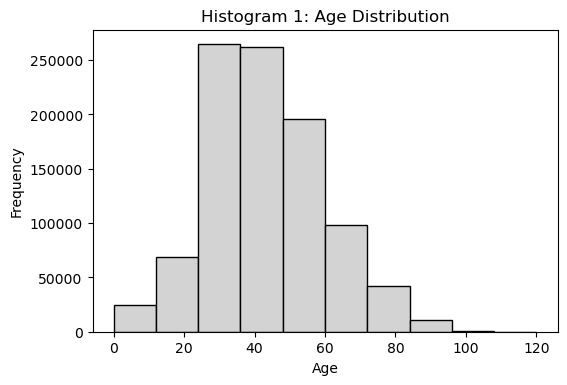

In [148]:
matplotlib.pyplot.figure(dpi = 100)
plt.hist(df1['edad'], ec = 'black', color = 'lightgray')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram 1: Age Distribution')
plt.show()

Histogram for number of COVID Cases:

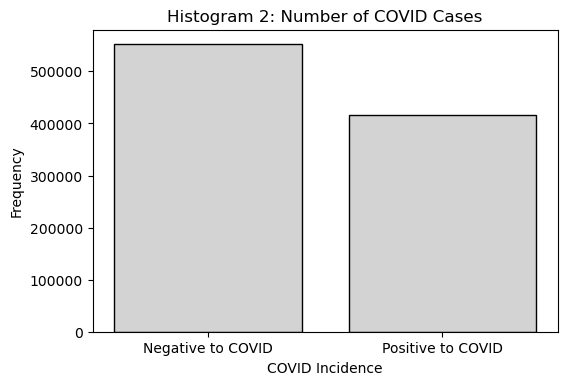

In [149]:
matplotlib.pyplot.figure(dpi = 100)
count = df1['covidPositivo'].value_counts()
count.index = ['Negative to COVID', 'Positive to COVID']
plt.bar(count.index, count.values, ec = 'black', color = 'lightgray')
plt.xlabel('COVID Incidence')
plt.ylabel('Frequency')
plt.title('Histogram 2: Number of COVID Cases')
plt.show()

Histogram for age range:

Average age is:  42.51549051756893
Standard deviation for age is:  16.640528648557325



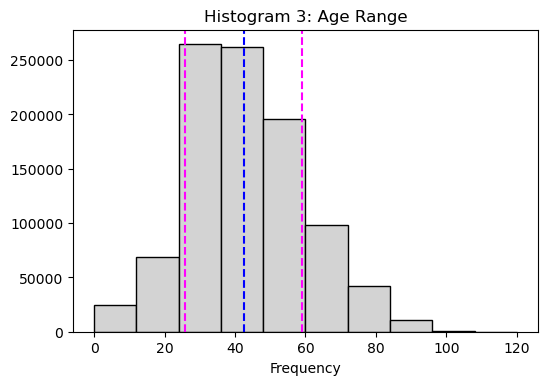

In [314]:
matplotlib.pyplot.figure(dpi = 100)
plt.title('Histogram 3: Age Range')
plt.hist(df1['edad'],ec='black', color = 'lightgray')
m = stats.mean(df1['edad'])
sd = stats.stdev(df1['edad'])
plt.axvline(m, color = 'blue', linestyle='dashed')
plt.axvline(m + sd, color='magenta', linestyle = 'dashed')
plt.axvline(m - sd, color='magenta', linestyle = 'dashed')
plt.xlabel('Frequency')
plt.ylabel('Age range')
print('Average age is: ', df['edad'].mean())
print('Standard deviation for age is: ', df['edad'].std())
print()

Box plot for age range:

<Figure size 600x400 with 0 Axes>

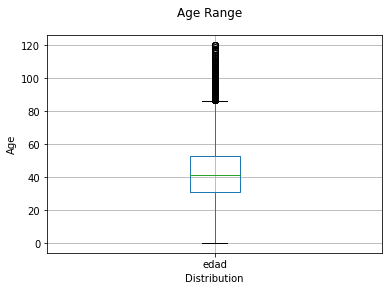

In [151]:
matplotlib.pyplot.figure(dpi = 100)
fig = plt.figure()
fig.suptitle('Age Range')
boxplot = df1.boxplot(column = [('edad')])
boxplot.set_ylabel('Age')
boxplot.set_xlabel('Distribution')
plt.show()

Pivot tables for deaths by gender:

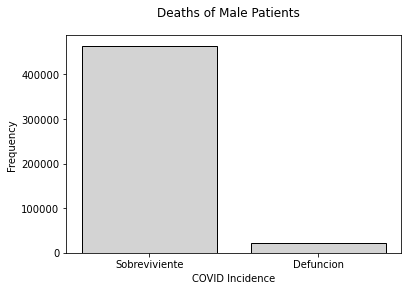

In [155]:
Pivot = df1.pivot_table(index = ["idPaciente"],
                        columns = ["pacienteGenero"],
                        values=["defuncion"],
                               aggfunc="sum")
fig = plt.figure()
fig.suptitle('Deaths of Male Patients')
count=Pivot[('defuncion', 1)].value_counts()
count.index = ['Survivors', 'Deaths']
plt.bar(count.index, count.values,ec ='black', color = 'lightgray')
plt.xlabel('COVID Incidence')
plt.ylabel('Frequency')
plt.show()

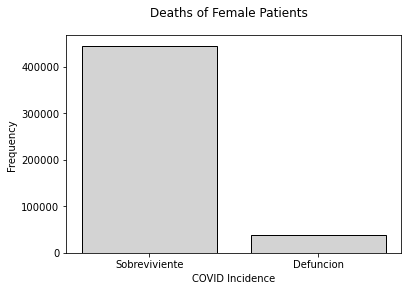

In [156]:
Pivot = df1.pivot_table(index = ["idPaciente"],
                        columns = ["pacienteGenero"],
                        values=["defuncion"],
                               aggfunc="sum")
fig = plt.figure()
fig.suptitle('Deaths of Female Patients')
count=Pivot[('defuncion', 0)].value_counts()
count.index = ['Survivors', 'Deaths']
plt.bar(count.index, count.values,ec ='black', color = 'lightgray')
plt.xlabel('COVID Incidence')
plt.ylabel('Frequency')
plt.show()

Selecting columns to create subplots:

In [85]:
columns = ['intubadoNum', 'UCINum', 'neumoniaNum', 'asmaNum',
       'hipertensionNum', 'diabetesNum', 'EPOCNum', 'inmunosupresionNum',
       'obesidad', 'tabaquismo',]

column_names = ['Intubated Patients', 'Patients in ICU', 'Patients with Pneumonia', 'Patients with Asthma', 
                'Patients with Hypertension', 'Patients with Diabetes', 'Patients with EPOC', 
                'Patients with Immunosupression', 'Patients with Obesity', 'Smoker Patients']

 Creating subplots:

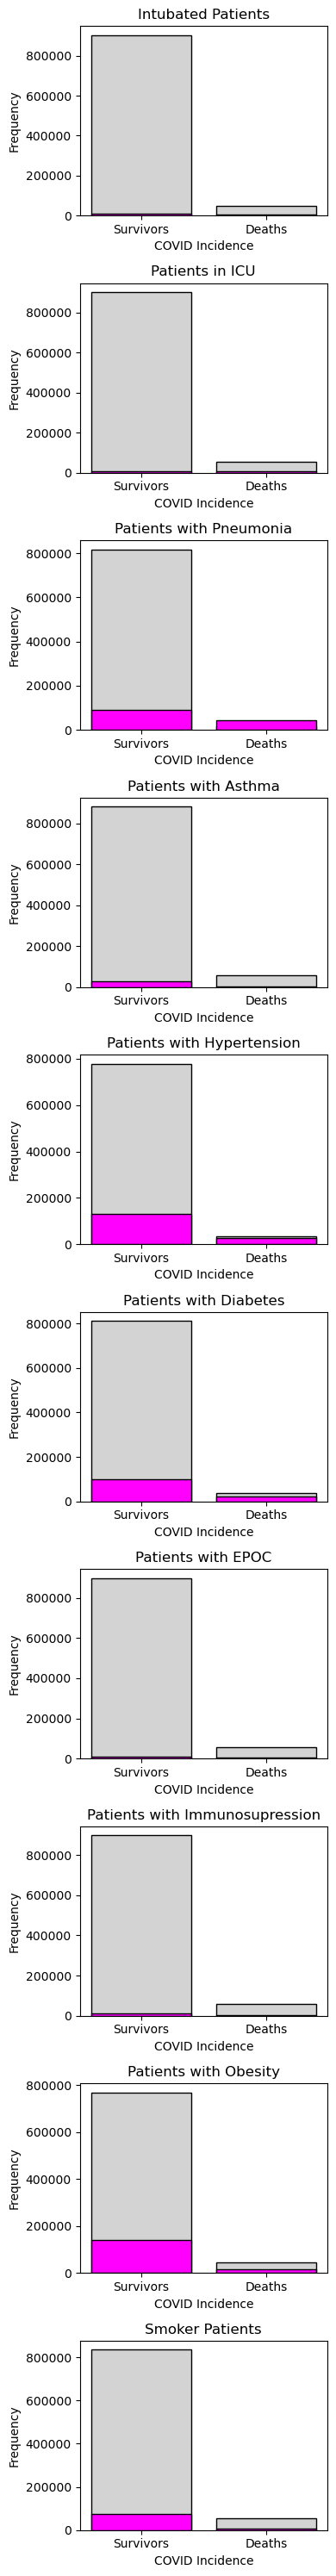

In [98]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(4, 3 * len(columns)), dpi=100)

for i, column in enumerate(columns):
    # Create a pivot table for the current column
    vPivot = df1.pivot_table(index=["idPaciente"],
                             columns=column,  
                             values=["defuncion"],
                             aggfunc="sum")

    colors = ['lightgray', 'magenta']  # Define the colors
    for idx, graph in enumerate(vPivot.columns.levels[1]):
        count = vPivot[('defuncion', graph)].value_counts()
        count.index = ['Survivors', 'Deaths']
        ax = axes[i] if len(columns) > 1 else axes
        # Use colors[idx % len(colors)] to cycle through the colors list
        ax.bar(count.index, count.values, color=colors[idx % len(colors)], ec='black')
        ax.set_xlabel('COVID Incidence')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{column_names[i]}')

plt.tight_layout()
plt.show()

Double-checking our dataset before starting with our models.

In [99]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968528 entries, 0 to 968527
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   fechaPrueba         968528 non-null  datetime64[ns]
 1   idPaciente          968528 non-null  int64         
 2   covidPositivo       968528 non-null  int64         
 3   covidNegativo       968528 non-null  int64         
 4   defuncion           968528 non-null  int64         
 5   intubadoNum         968528 non-null  int64         
 6   UCINum              968528 non-null  int64         
 7   neumoniaNum         968528 non-null  int64         
 8   asmaNum             968528 non-null  int64         
 9   hipertensionNum     968528 non-null  int64         
 10  diabetesNum         968528 non-null  int64         
 11  EPOCNum             968528 non-null  int64         
 12  inmunosupresionNum  968528 non-null  int64         
 13  obesidad            968528 no

Importing sklearn package for preprocessing data, by converting ''pacienteGenero'' (which indicates the gender of the patient) to a column with binary values (0=female).

In [100]:
from sklearn.preprocessing import LabelEncoder

In [101]:
le=LabelEncoder()

In [129]:
df1['pacienteGenero'] = le.fit_transform(df1['pacienteGenero'])

Designating new dataframe for modeling. ''Df1'' stays untouched.

In [130]:
df_modeling = df1.drop(['estado', 'municipio', 'fechaPrueba', 'idPaciente', 'state'], axis=1)

In [217]:
df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968528 entries, 0 to 968527
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Positive to Covid               968528 non-null  int64  
 1   Negative to Covid               968528 non-null  int64  
 2   Deaths                          968528 non-null  int64  
 3   Intubated Patients              968528 non-null  int64  
 4   Patients in ICU                 968528 non-null  int64  
 5   Patients with Pneumonia         968528 non-null  int64  
 6   Patients with Asthma            968528 non-null  int64  
 7   Patients with Hypertension      968528 non-null  int64  
 8   Patients with Diabetes          968528 non-null  int64  
 9   Patients with EPOC              968528 non-null  int64  
 10  Patients with Immunosupression  968528 non-null  int64  
 11  Patients with Obesity           968528 non-null  int64  
 12  Smoker Patients 

In [218]:
df_modeling.columns = ['Positive to Covid', 'Negative to Covid', 'Deaths', 'Intubated Patients', 'Patients in ICU', 
              'Patients with Pneumonia', 'Patients with Asthma', 'Patients with Hypertension', 
              'Patients with Diabetes', 'Patients with EPOC', 'Patients with Immunosupression', 
              'Patients with Obesity', 'Smoker Patients', 'Gender of Patient', 'Type of Patient', 
              'Age','Latitude', 'Longitude']

### **3.c Correlation Maps**  <a class="anchor" id="3c"></a>

Creating correlation matrix to then create a heatmap:

In [219]:
correlation_matrix = df_modeling.corr()

Visualizing the correlation matrix using a heatmap:

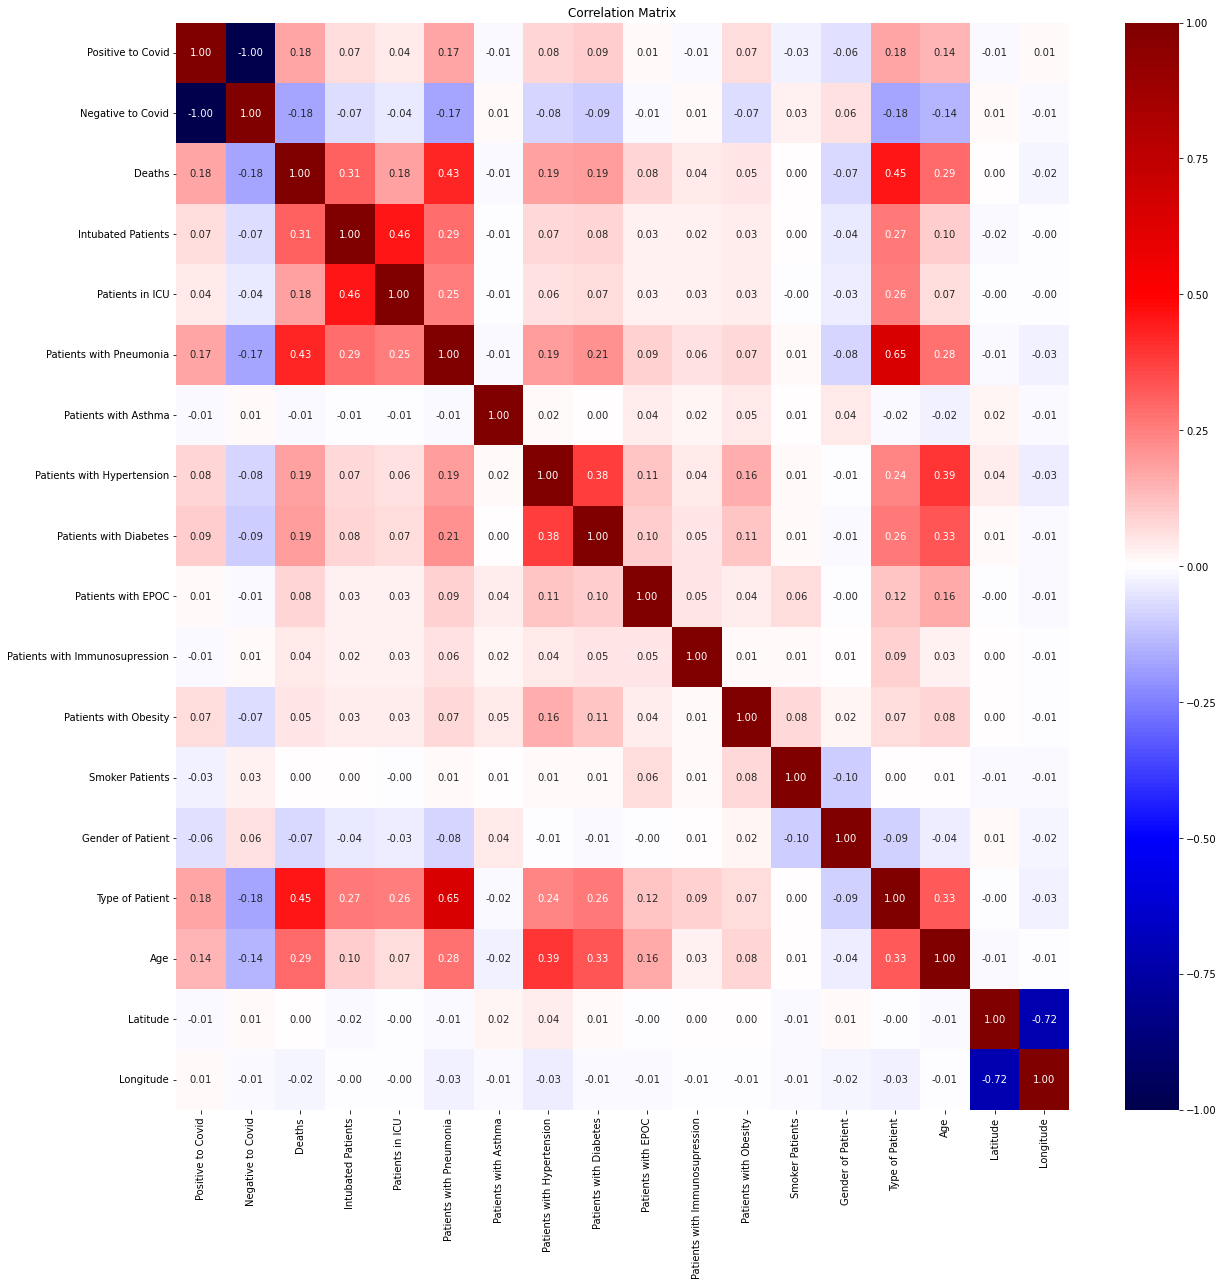

In [220]:
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='seismic', fmt=".2f");
plt.title('Correlation Matrix')
plt.show()

Correlation map of variables x deaths:

In [221]:
import plotly.express as px
fig = px.bar(correlation_matrix['Deaths'].sort_values(ascending = False),
             color = 'value', title = 'Correlation Plot')
fig.update_layout(yaxis_title='Correlation Coefficient')
fig.show()

# Save the figure as an HTML file
fig.write_html('correlation_plot.html')

Noticing the imbalance of the variable ''deaths'' in our data:

In [222]:
df_modeling.groupby('Deaths')['Deaths'].count() #Hacer graficas de barras

Deaths
0    909194
1     59334
Name: Deaths, dtype: int64

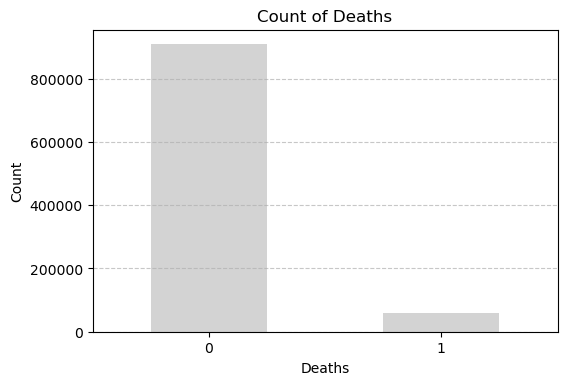

In [223]:
# Grouping by 'Deaths' and counting occurrences
death_counts = df_modeling.groupby('Deaths')['Deaths'].count()

# Plotting the bar graph
plt.figure(dpi = 100)
death_counts.plot(kind='bar', color = 'lightgray')
plt.xlabel('Deaths')
plt.ylabel('Count')
plt.title('Count of Deaths')
plt.xticks(rotation=0)  # Keeping the x-ticks labels horizontal for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding a grid for the y-axis for better readability
plt.show()

## **4. Machine Learning Models**  <a class="anchor" id="4"></a>

### **4.a XG Boost on Initial Data (no resampling, no hyper-parameter tuning)**  <a class="anchor" id="4a"></a>

Assigning dependent variable (deaths) and independent variables (rest of the data frame).

In [312]:
X = df_modeling.drop('Deaths', axis = 1).values
y = df_modeling['Deaths'].values

Splitting dataset into training and testing:

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

Fitting XGBoost:

In [280]:
cv_xgb = xgb.XGBClassifier(objective = 'binary:logistic', seed = 42, n_estimators = 100, learning_rate = 0.01)

cv_xgb.fit(X_train,
           y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Prediction:

In [281]:
y_pred = cv_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

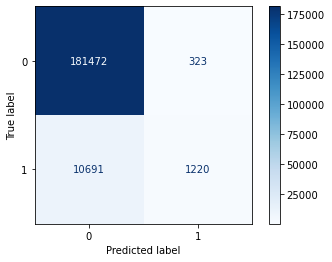

In [282]:
dis = ConfusionMatrixDisplay(cm)
dis.plot(cmap='Blues')
plt.show()

In [283]:
accuracy_xgboost = accuracy_score(y_test, y_pred)
print(f'Accuracy score of XGBoost is {round(accuracy_xgboost*100,2)}%')

Accuracy score of XGBoost is 94.31%


Classification report:

In [284]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    181795
           1       0.79      0.10      0.18     11911

    accuracy                           0.94    193706
   macro avg       0.87      0.55      0.58    193706
weighted avg       0.93      0.94      0.92    193706



In [285]:
precision_xgboost = precision_score(y_test, y_pred)
recall_xgboost = recall_score(y_test, y_pred)

print(f'Precision score of XGBoost is {round(precision_xgboost*100,2)}%')
print(f'Recall score of XGBoost is {round(recall_xgboost*100,2)}%')

Precision score of XGBoost is 79.07%
Recall score of XGBoost is 10.24%


The XGBoost might be underperforming given that, as we saw before, our dataset is unbalanced. Let's try to balance it out:

### **4.b Resampling: SMOTE vs ROS vs RUS**  <a class="anchor" id="4b"></a>

RANDOM OVERSAMPLING

Precision of the final model: 0.3112092215613108


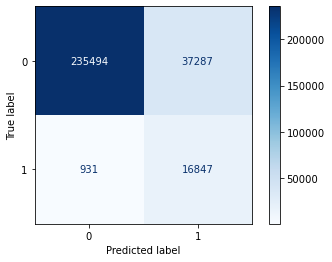

              precision    recall  f1-score   support

           0       1.00      0.86      0.92    272781
           1       0.31      0.95      0.47     17778

    accuracy                           0.87    290559
   macro avg       0.65      0.91      0.70    290559
weighted avg       0.95      0.87      0.90    290559

Accuracy score of ROS is 86.85%
Precision score of ROS is 31.12%
Recall score of ROS is 94.76%


In [286]:
from imblearn.over_sampling import RandomOverSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Apply Random Oversampling
over = RandomOverSampler(sampling_strategy = 'auto')
X_ros, y_ros = over.fit_resample(X, y)

# Train the final model with the best parameters on the full training set
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_ros, y_ros, test_size=0.3, shuffle=True)
final_model = xgb.XGBClassifier(objective='binary:logistic')
final_model.fit(X_train2, y_train2)

# Evaluate the final model on the test set
y_pred = final_model.predict(X_test)
final_precision = precision_score(y_test, y_pred)
print("Precision of the final model:", final_precision)

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
dis = ConfusionMatrixDisplay(cm)
dis.plot(cmap='Blues')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))

y_test_ros = y_test
y_pred_ros = y_pred

precision_ROS = precision_score(y_test, y_pred)
recall_ROS = recall_score(y_test, y_pred)
accuracy_ROS = accuracy_score(y_test, y_pred)

print(f'Accuracy score of ROS is {round(accuracy_ROS*100,2)}%')
print(f'Precision score of ROS is {round(precision_ROS*100,2)}%')
print(f'Recall score of ROS is {round(recall_ROS*100,2)}%')

RANDOM UNDERSAMPLING

Precision of the final model: 0.307242969527082


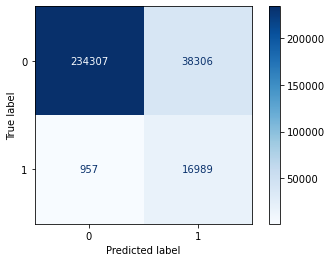

              precision    recall  f1-score   support

           0       1.00      0.86      0.92    272613
           1       0.31      0.95      0.46     17946

    accuracy                           0.86    290559
   macro avg       0.65      0.90      0.69    290559
weighted avg       0.95      0.86      0.89    290559

Accuracy score of RUS is 86.49%
Precision score of RUS is 30.72%
Recall score of RUS is 94.67%


In [287]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

from imblearn.under_sampling import RandomUnderSampler

# Apply Random Undersampling
under = RandomUnderSampler(sampling_strategy = 'auto')
X_rus, y_rus = under.fit_resample(X, y)

# Train the final model with the best parameters on the full training set
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_rus, y_rus, test_size=0.3, shuffle=True)
final_model = xgb.XGBClassifier(objective='binary:logistic')
final_model.fit(X_train2, y_train2)

# Evaluate the final model on the test set
y_pred = final_model.predict(X_test)
final_precision = precision_score(y_test, y_pred)
print("Precision of the final model:", final_precision)

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
dis = ConfusionMatrixDisplay(cm)
dis.plot(cmap='Blues')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))

y_test_rus = y_test
y_pred_rus = y_pred

precision_RUS = precision_score(y_test, y_pred)
recall_RUS = recall_score(y_test, y_pred)
accuracy_RUS = accuracy_score(y_test, y_pred)

print(f'Accuracy score of RUS is {round(accuracy_RUS*100,2)}%')
print(f'Precision score of RUS is {round(precision_RUS*100,2)}%')
print(f'Recall score of RUS is {round(recall_RUS*100,2)}%')

SMOTE

Precision of the final model: 0.4103472934738675


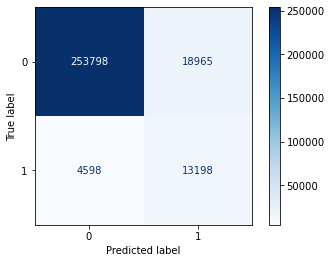

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    272763
           1       0.41      0.74      0.53     17796

    accuracy                           0.92    290559
   macro avg       0.70      0.84      0.74    290559
weighted avg       0.95      0.92      0.93    290559

Accuracy score of SMOTE is 91.89%
Precision score of SMOTE is 41.03%
Recall score of SMOTE is 74.16%


In [288]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

over =  SMOTE(sampling_strategy = 'auto')
X_smote, y_smote = over.fit_resample(X,y)

# Train the final model with the best parameters on the full training set
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_smote, y_smote, test_size=0.3, shuffle=True)
final_model = xgb.XGBClassifier(objective='binary:logistic')
final_model.fit(X_train2, y_train2)

# Evaluate the final model on the test set
y_pred = final_model.predict(X_test)
final_precision = precision_score(y_test, y_pred)
print("Precision of the final model:", final_precision)

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
dis = ConfusionMatrixDisplay(cm)
dis.plot(cmap='Blues')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))

y_test_smote = y_test
y_pred_smote = y_pred

precision_SMOTE = precision_score(y_test, y_pred)
recall_SMOTE = recall_score(y_test, y_pred)
accuracy_SMOTE = accuracy_score(y_test, y_pred)

print(f'Accuracy score of SMOTE is {round(accuracy_SMOTE*100,2)}%')
print(f'Precision score of SMOTE is {round(precision_SMOTE*100,2)}%')
print(f'Recall score of SMOTE is {round(recall_SMOTE*100,2)}%')

In [289]:
pd.DataFrame({'Score': ['Accuracy Score', 'Precision Score', 'Recall Score'], 
              'Random Oversampling': [round(accuracy_ROS*100,2), round(precision_ROS*100,2), round(recall_ROS*100,2)], 
              'Random Undersampling': [round(accuracy_RUS*100,2), round(precision_RUS*100,2), round(recall_RUS*100,2)],
              'SMOTE': [round(accuracy_SMOTE*100,2), round(precision_SMOTE*100,2), round(recall_SMOTE*100,2)]})

,Score,Random Oversampling,Random Undersampling,SMOTE
0,Accuracy Score,86.85,86.49,91.89
1,Precision Score,31.12,30.72,41.03
2,Recall Score,94.76,94.67,74.16


Optimizing our Model

### **4.c Searching for the best threshold using the ROC Curve**  <a class="anchor" id="4c"></a>


In [297]:
y_pred = cv_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred_smote)

In [300]:
y_pred_prob = cv_xgb.predict_proba(X_test)[:, 1]

In [301]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("ROC AUC: {:.4f}".format(roc_auc))

ROC AUC: 0.9498


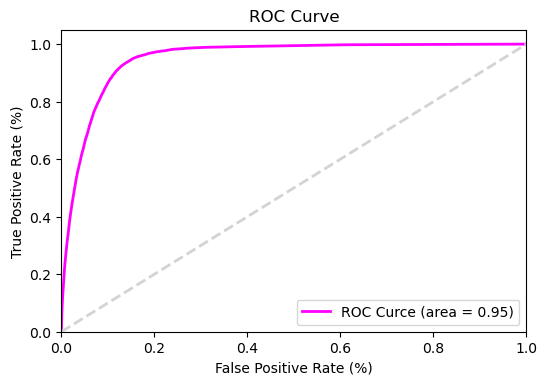

In [302]:
# ROC Curve
plt.figure(dpi = 100)
plt.plot(fpr, tpr, color='magenta', lw=2, label='ROC Curce (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (%)')
plt.ylabel('True Positive Rate (%)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [303]:
recall_score(y_test,y_pred_smote)

0.10901326140705776

In [306]:
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold: {:.4f}".format(optimal_threshold))

Optimal threshold: 0.0876


In [307]:
closest_point = np.sqrt((1-tpr)**2 + fpr**2)
optimal_idx_closest = np.argmin(closest_point)
optimal_threshold_closest = thresholds[optimal_idx_closest]
optimal_threshold_closest

0.1130312

### **4.d Hyper-parameter tuning with best resampler method**  <a class="anchor" id="4d"></a>

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Define your objective function with a fixed data split
def objective(trial):
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 100),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10),
        # Add other parameters you want to tune here
    }

    # Define the model
    model = xgb.XGBClassifier(objective='binary:logistic', **params, seed=42)

    # Train the model on the fixed training set
    model.fit(X_train2, y_train2)

    # Predict on the fixed test set
    y_pred = model.predict(X_test)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print precision score in each iteration
    print(f"Iteration {trial.number}: Precision = {precision}, Recall = {recall}, F1 = {f1}")

    return f1

# Define the study
study = optuna.create_study(direction='maximize')

# Optimize the study
study.optimize(objective, n_trials=50)

# Get the best parameters
best_params = study.best_params

# Print the best parameters
print("Best parameters:", best_params)

# Train the final model with the best parameters on the full training set
final_model = xgb.XGBClassifier(objective='binary:logistic', **best_params, seed=42)
final_model.fit(X_train, y_train)

# Evaluate the final model on the test set
y_pred_final = final_model.predict(X_test)
final_precision = precision_score(y_test, y_pred_final)
print("Precision of the final model:", final_precision)

## **5. Best model**  <a class="anchor" id="5"></a>

### **5.a Interpretating best features**  <a class="anchor" id="5a"></a>

In [ ]:
X = df_modeling.drop('Deaths', axis = 1)
y = df_modeling['Deaths']

In [313]:
import xgboost
import shap

# train XGBoost model
# X, y = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X, y)

# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

/Users/dianamueses/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[03:18:09] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

100%|===================| 968313/968528 [69:44<00:00]        

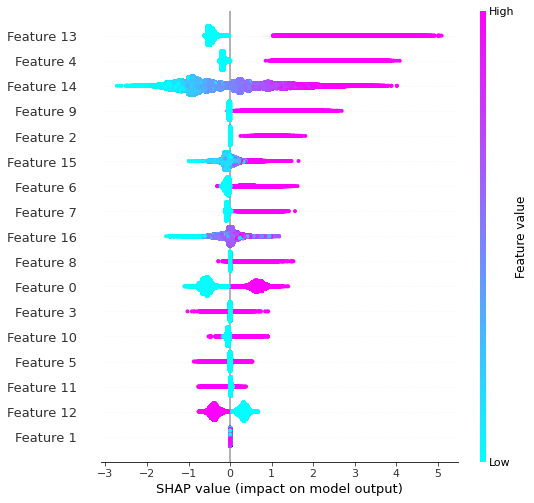

In [315]:
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0), 
                    max_display=20, color=plt.get_cmap("cool"))

[texto del vínculo](https://)